<a href="https://colab.research.google.com/github/chryssa-pat/Decision-Theory/blob/main/Project_2/Counterfeiting_of_banknotes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture

# **Split Data**

In [4]:
# Load data
file_path = "/content/drive/MyDrive/data/data.csv"

# Read Data
data = pd.read_csv(file_path)

# Split features and labels
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # Last column (labels 0,1)

# Split into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# **Parzen Windows**

# PCA

Explained Variance Ratio: [0.55211493 0.31525425]


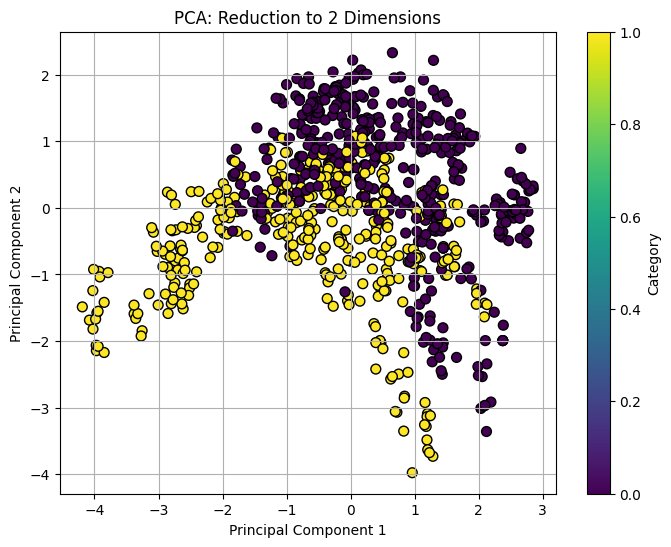

In [ ]:
# PCA for Dimensionality Reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# percentage of variance explained by each principal component
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title("PCA: Reduction to 2 Dimensions")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Category")
plt.grid()
plt.show()


# Training-Validation


Parzen Window Classification with h = 0.1
Training Accuracy: 0.8128797083839611
Validation Accuracy: 0.7992700729927007


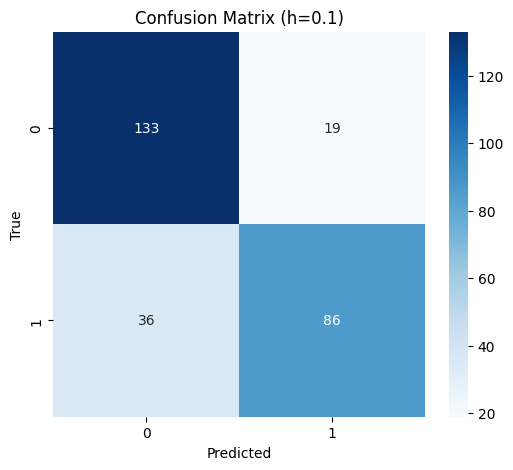

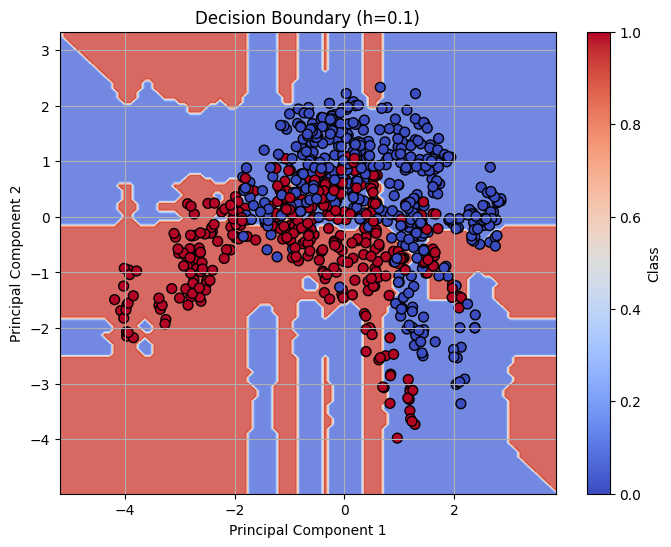


Parzen Window Classification with h = 0.5
Training Accuracy: 0.764277035236938
Validation Accuracy: 0.7445255474452555


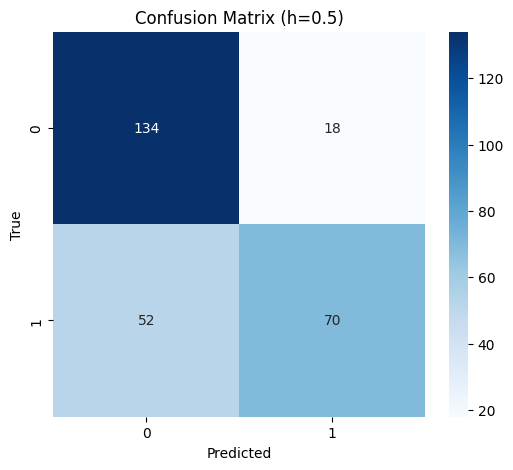

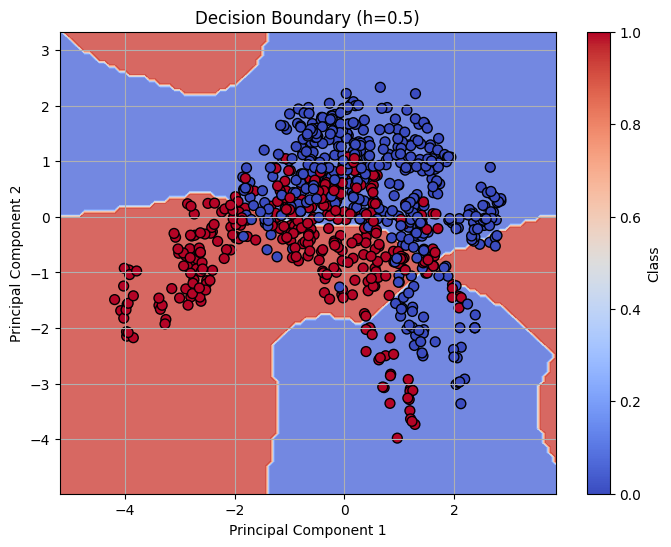


Parzen Window Classification with h = 1.0
Training Accuracy: 0.7083839611178615
Validation Accuracy: 0.6934306569343066


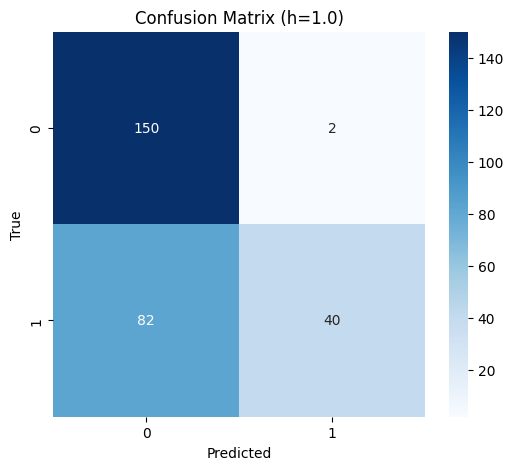

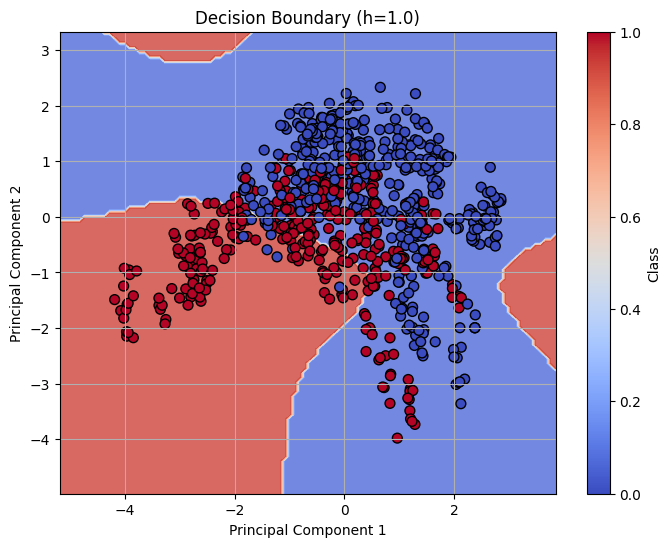


Parzen Window Classification with h = 2.0
Training Accuracy: 0.6403402187120292
Validation Accuracy: 0.6131386861313869


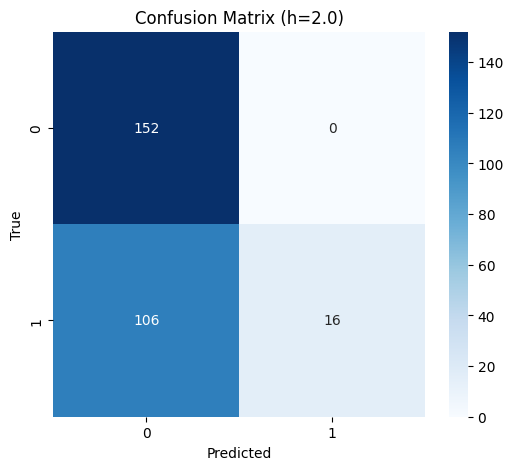

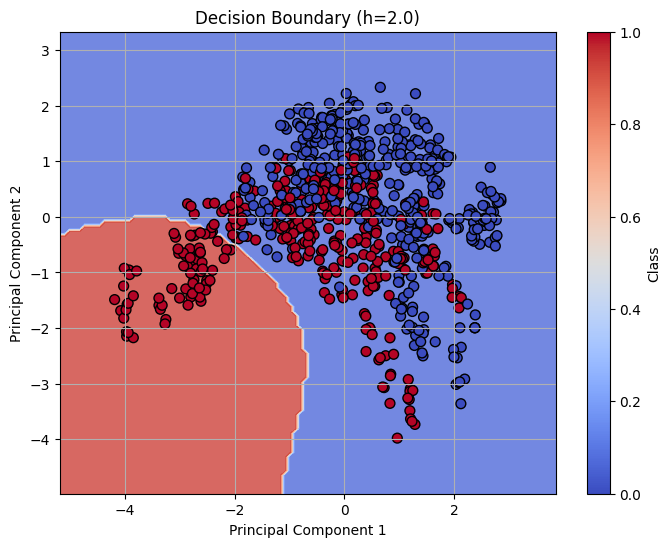

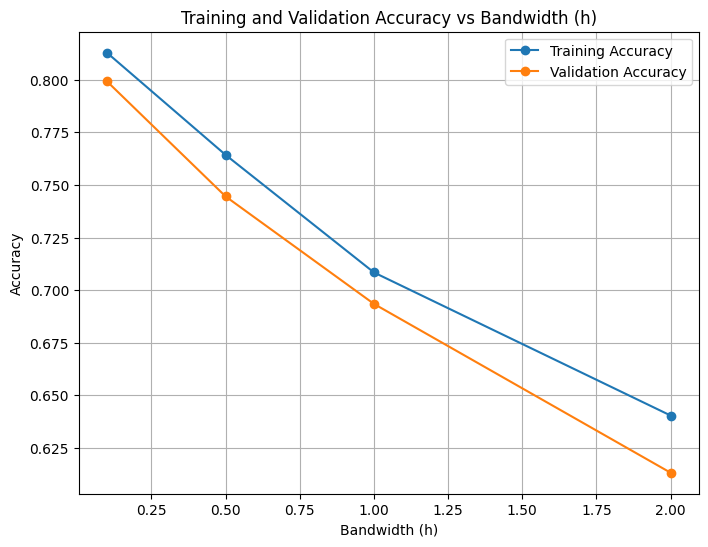

In [ ]:
# Gaussian kernel function
def gaussian_kernel(x, h):
    # Calculate the Gaussian kernel value
    return np.exp(-0.5 * (x / h)**2) / (np.sqrt(2 * np.pi) * h)

# Parzen Window Classifier
def parzen_window_classifier(data, labels, query_point, h):
    # Classify a query point using Parzen Windows.
    unique_classes = np.unique(labels)
    densities = {}

    for c in unique_classes:
        class_data = data[labels == c]
        densities[c] = np.sum(gaussian_kernel(query_point - class_data, h))

    # Normalize the densities
    total_density = sum(densities.values())
    for c in densities:
        densities[c] /= total_density

    # Return the class with the highest normalized density
    return max(densities, key=densities.get)


# List for accuracy values for training and validation
accuracy_train_values = []
accuracy_val_values = []
h_values = [0.1, 0.5, 1.0, 2.0]
for h in h_values:
    # Training set predictions
    y_train_pred = []
    for query_point in X_train_pca:
        pred_class = parzen_window_classifier(X_train_pca, y_train.values, query_point, h)
        y_train_pred.append(pred_class)

    y_train_pred = np.array(y_train_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    accuracy_train_values.append(train_accuracy)

    # Validation set predictions
    y_val_pred = []
    for query_point in X_val_pca:
        pred_class = parzen_window_classifier(X_train_pca, y_train.values, query_point, h)
        y_val_pred.append(pred_class)

    y_val_pred = np.array(y_val_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    accuracy_val_values.append(val_accuracy)

    print(f"\nParzen Window Classification with h = {h}")
    print("Training Accuracy:", train_accuracy)
    print("Validation Accuracy:", val_accuracy)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title(f"Confusion Matrix (h={h})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Decision Boundary
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    Z = np.array([parzen_window_classifier(X_train_pca, y_train.values, np.array([x, y]), h) for x, y in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', cmap='coolwarm', s=50)
    plt.title(f"Decision Boundary (h={h})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.colorbar(label="Class")
    plt.grid()
    plt.show()

# Plot accuracy values for training and validation
plt.figure(figsize=(8, 6))
plt.plot(h_values, accuracy_train_values, label="Training Accuracy", marker='o')
plt.plot(h_values, accuracy_val_values, label="Validation Accuracy", marker='o')
plt.title("Training and Validation Accuracy vs Bandwidth (h)")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# Testing


Parzen Window Classification on Test Set with h = 0.5
Accuracy: 0.7563636363636363
              precision    recall  f1-score   support

           0       0.72      0.92      0.81       153
           1       0.84      0.56      0.67       122

    accuracy                           0.76       275
   macro avg       0.78      0.74      0.74       275
weighted avg       0.77      0.76      0.75       275



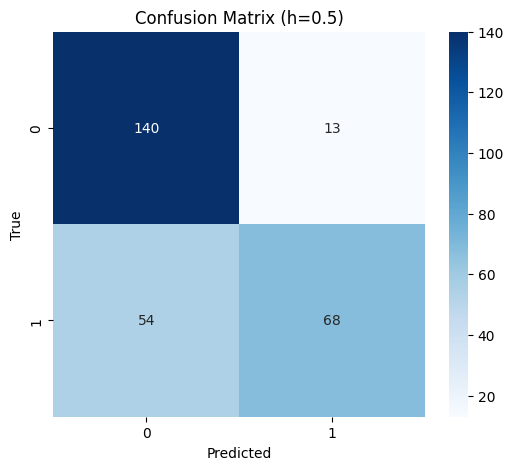

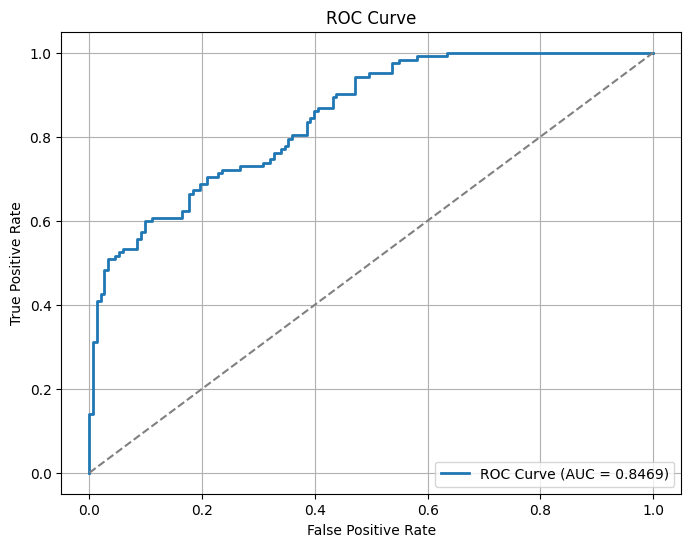

In [ ]:
# Selected h
h = 0.5

y_test_pred = []
for query_point in X_test_pca:
    pred_class = parzen_window_classifier(X_train_pca, y_train.values, query_point, h)
    y_test_pred.append(pred_class)

y_test_pred = np.array(y_test_pred)
print(f"\nParzen Window Classification on Test Set with h = {h}")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title(f"Confusion Matrix (h={h})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Calculation of densities and probabilities for the ROC curve
unique_classes = np.unique(y_test)

# Compute probabilities for each class in the test set
y_test_probas = []
for query_point in X_test_pca:
    densities = {}
    for c in unique_classes:
        class_data = X_train_pca[y_train == c]
        densities[c] = np.sum(gaussian_kernel(query_point - class_data, h))

    # Normalize probabilities
    total_density = sum(densities.values())
    probas = [densities[c] / total_density for c in unique_classes]
    y_test_probas.append(probas)

# Convert to numpy array
y_test_probas = np.array(y_test_probas)

# Compute ROC curve and AUC for the positive class (positive class is class 1)
fpr, tpr, _ = roc_curve(y_test, y_test_probas[:, 1])
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()




# **K-NN**

# Training-Validation


k-NN Classification with k = 1
Accuracy on training set: 1.0
Accuracy on validation set: 1.0


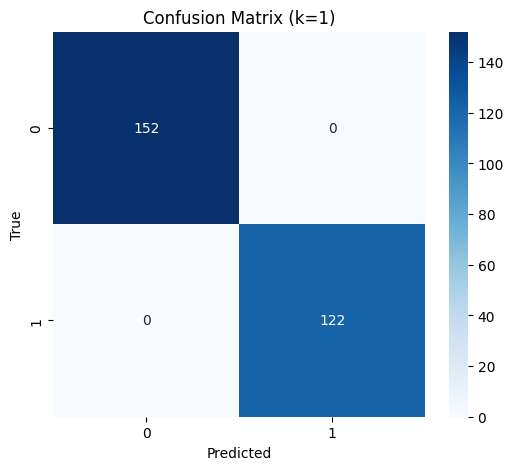


k-NN Classification with k = 3
Accuracy on training set: 0.9975698663426489
Accuracy on validation set: 1.0


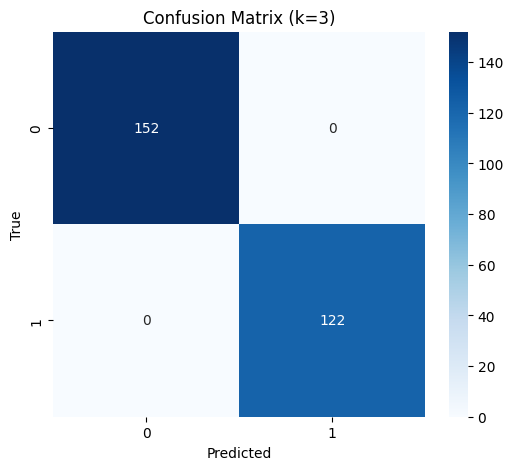


k-NN Classification with k = 5
Accuracy on training set: 0.9975698663426489
Accuracy on validation set: 1.0


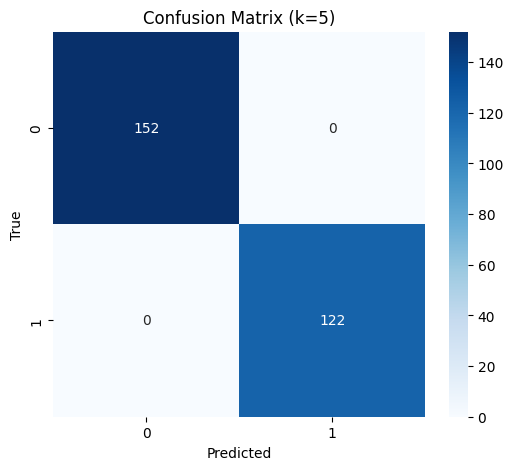


k-NN Classification with k = 7
Accuracy on training set: 0.9975698663426489
Accuracy on validation set: 1.0


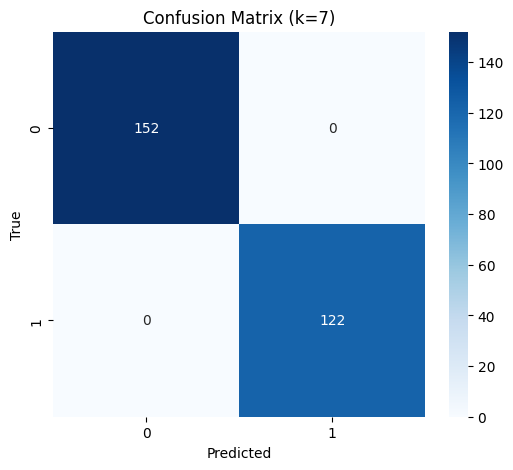


k-NN Classification with k = 9
Accuracy on training set: 0.9975698663426489
Accuracy on validation set: 1.0


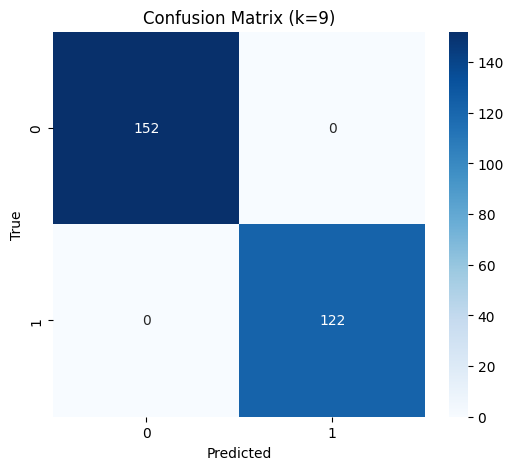


k-NN Classification with k = 11
Accuracy on training set: 0.9927095990279465
Accuracy on validation set: 1.0


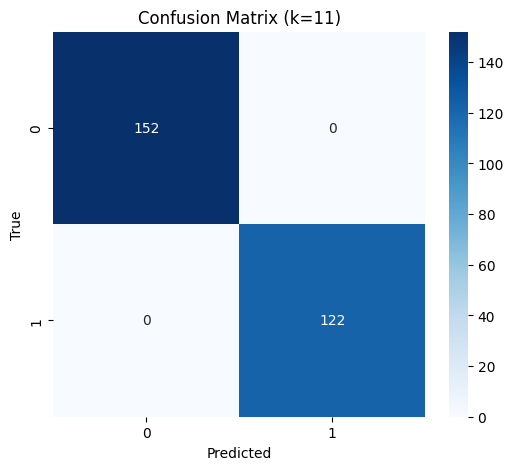


k-NN Classification with k = 13
Accuracy on training set: 0.9902794653705954
Accuracy on validation set: 0.9890510948905109


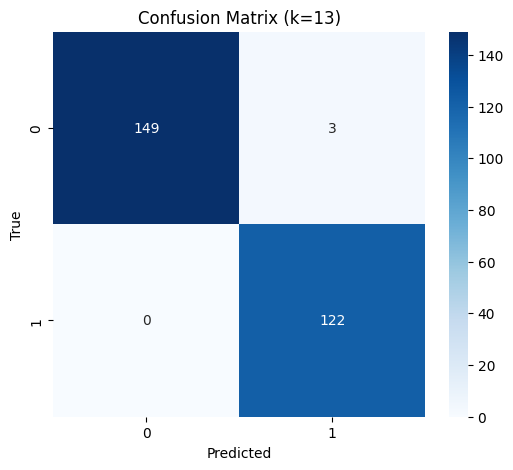


k-NN Classification with k = 15
Accuracy on training set: 0.9902794653705954
Accuracy on validation set: 0.9890510948905109


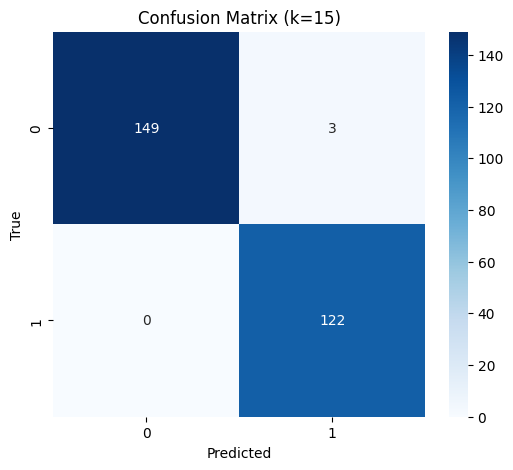

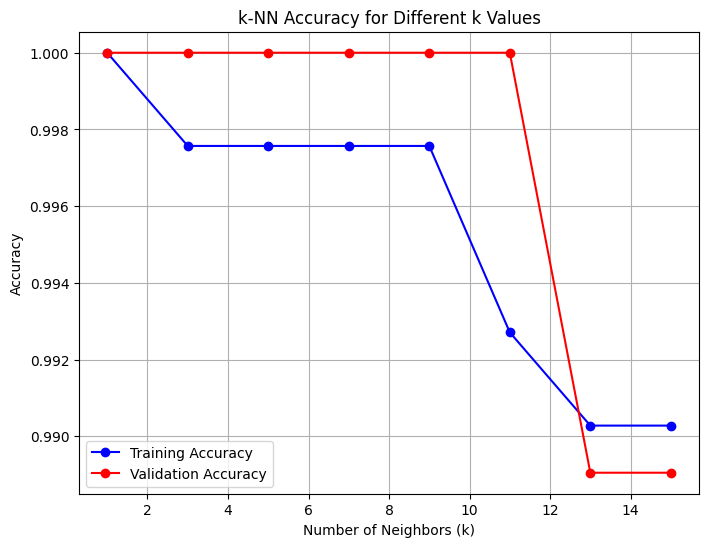

In [ ]:
# k-NN Classification
k_values = [1, 3, 5, 7, 9, 11, 13, 15]
accuracy_scores_train = []
accuracy_scores_validation = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)

    # Training set predictions
    y_train_pred = knn.predict(X_train_scaled)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_scores_train.append(accuracy_train)

    # Validation set predictions
    y_val_pred = knn.predict(X_val_scaled)
    accuracy_validation = accuracy_score(y_val, y_val_pred)
    accuracy_scores_validation.append(accuracy_validation)

    print(f"\nk-NN Classification with k = {k}")
    print("Accuracy on training set:", accuracy_train)
    print("Accuracy on validation set:", accuracy_validation)

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title(f"Confusion Matrix (k={k})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Plot k-NN accuracies
plt.figure(figsize=(8, 6))
plt.plot(k_values, accuracy_scores_train, marker='o', linestyle='-', color='b', label="Training Accuracy")
plt.plot(k_values, accuracy_scores_validation, marker='o', linestyle='-', color='r', label="Validation Accuracy")
plt.title("k-NN Accuracy for Different k Values")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# Testing


k-NN Classification on Test Set with k = 9
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



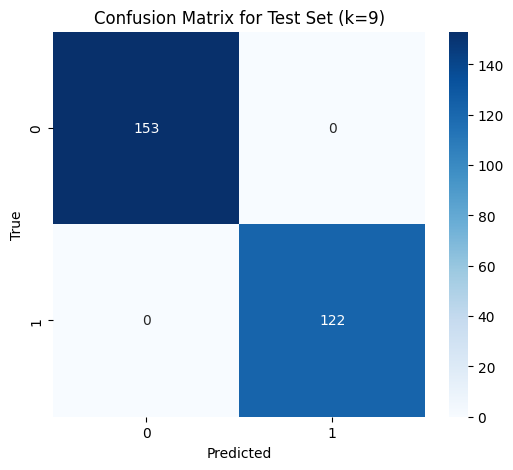

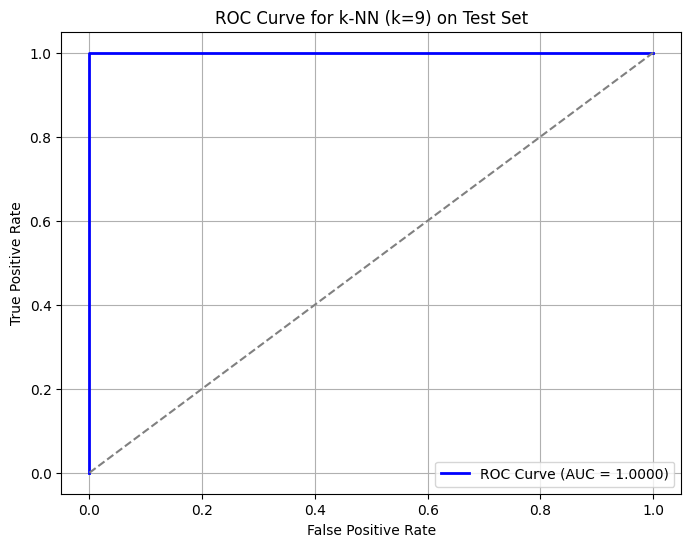

In [ ]:
# Selected k
k=9

# Test set predictions
knn_best = KNeighborsClassifier(n_neighbors=k)
knn_best.fit(X_train_scaled, y_train)
y_test_pred_knn = knn_best.predict(X_test_scaled)

print(f"\nk-NN Classification on Test Set with k = {k}")
print("Accuracy:", accuracy_score(y_test, y_test_pred_knn))
print(classification_report(y_test, y_test_pred_knn))

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix for Test Set (k={k})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Compute and plot the ROC Curve for the test set
y_test_prob = knn_best.predict_proba(X_test_scaled)  # Probabilities for the classes
fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])  # Use probabilities for the positive class
roc_auc = auc(fpr, tpr)  # Compute AUC

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal for random classification
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for k-NN (k={k}) on Test Set')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **SVM**

# Training-Validation

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best Parameters for linear kernel: {'C': 10}

Train Accuracy (linear kernel): 0.9927095990279465
Validation Accuracy (linear kernel): 0.9890510948905109


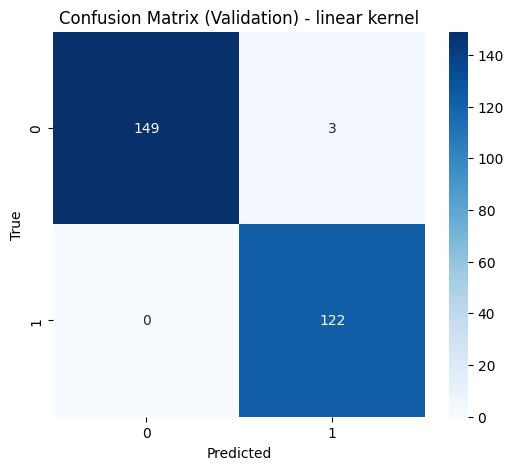

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best Parameters for rbf kernel: {'C': 10, 'gamma': 0.1}

Train Accuracy (rbf kernel): 1.0
Validation Accuracy (rbf kernel): 1.0


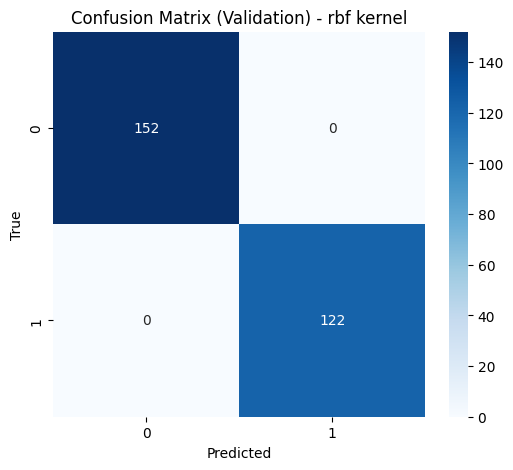

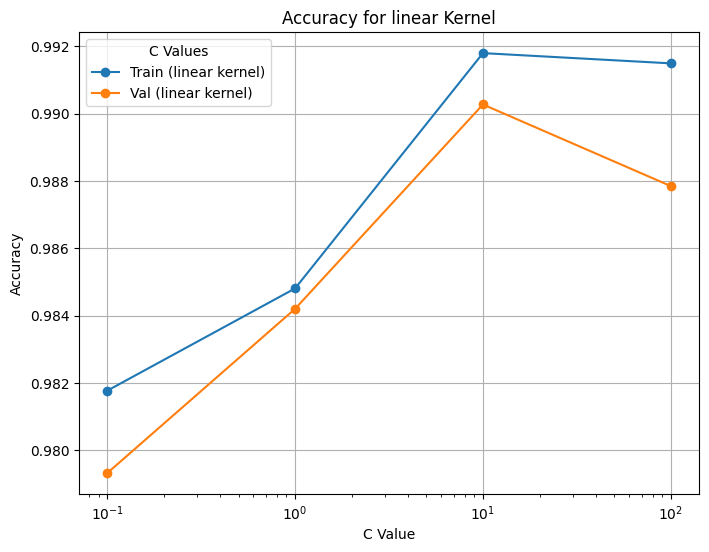

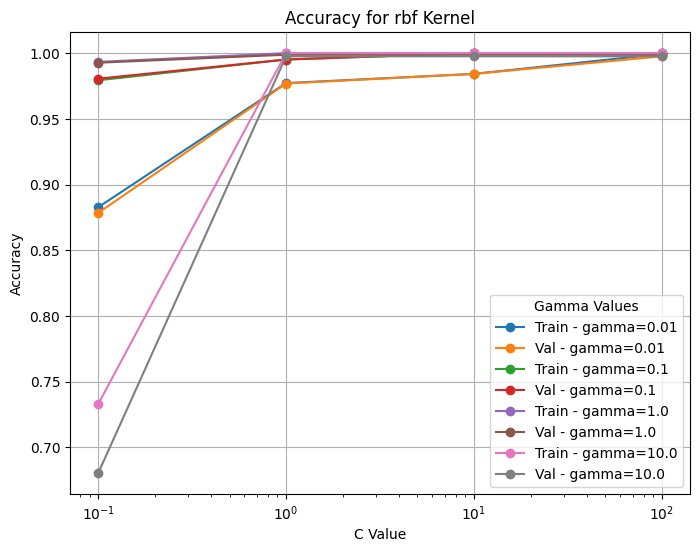

In [ ]:
# function for linear and RBF SVM
def svm_grid_search(X_train, y_train, X_val, y_val, kernel, param_grid):

    #Apply SVM with hyperparameter grid search
    grid_search = GridSearchCV(SVC(kernel=kernel, probability=True), param_grid, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Best parameters
    best_params = grid_search.best_params_
    print(f"\nBest Parameters for {kernel} kernel: {best_params}")


    best_model = grid_search.best_estimator_
    #Training set predictions
    y_train_pred = best_model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Validation set predictions
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"\nTrain Accuracy ({kernel} kernel): {train_accuracy}")
    print(f"Validation Accuracy ({kernel} kernel): {val_accuracy}")

    # Confusion Matrix
    cm_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title(f"Confusion Matrix (Validation) - {kernel} kernel")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return grid_search

# Parameter grid for linear SVM
linear_param_grid = {'C': [0.1, 1, 10, 100]}

# linear SVM
linear_svm_model = svm_grid_search(X_train_scaled, y_train, X_val_scaled, y_val, kernel='linear', param_grid=linear_param_grid)

# Parameter grid for non-linear SVM - RBF kernel
rbf_param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10]}

# non-linear SVM - RBF kernel
rbf_svm_model = svm_grid_search(X_train_scaled, y_train, X_val_scaled, y_val, kernel='rbf', param_grid=rbf_param_grid)

# plot the accuracies
def plot_accuracies(grid_search, kernel):

    #Create line plots for each value of C (and gamma for RBF) for Training and Validation accuracies
    param_C = grid_search.cv_results_['param_C'].data
    train_accuracies = grid_search.cv_results_['mean_train_score']
    val_accuracies = grid_search.cv_results_['mean_test_score']

    # Create the plot
    plt.figure(figsize=(8, 6))

    # For RBF SVM
    if kernel == 'rbf':
        param_gamma = grid_search.cv_results_['param_gamma'].data
        for gamma_value in np.unique(param_gamma):
            train_accuracies_for_gamma = [train_accuracies[i] for i in range(len(train_accuracies)) if param_gamma[i] == gamma_value]
            val_accuracies_for_gamma = [val_accuracies[i] for i in range(len(val_accuracies)) if param_gamma[i] == gamma_value]
            C_values_for_gamma = [param_C[i] for i in range(len(param_C)) if param_gamma[i] == gamma_value]

            # Plot the line for the specific gamma value
            plt.plot(C_values_for_gamma, train_accuracies_for_gamma, marker='o', label=f'Train - gamma={gamma_value}')
            plt.plot(C_values_for_gamma, val_accuracies_for_gamma, marker='o', label=f'Val - gamma={gamma_value}')

    else:
        # For linear SVM
        plt.plot(param_C, train_accuracies, marker='o', label=f'Train ({kernel} kernel)')
        plt.plot(param_C, val_accuracies, marker='o', label=f'Val ({kernel} kernel)')


    plt.xscale('log')
    plt.xlabel('C Value')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy for {kernel} Kernel')
    plt.legend(title="Gamma Values" if kernel == 'rbf' else "C Values")
    plt.grid(True)
    plt.show()

# Create plot for Linear SVM
plot_accuracies(linear_svm_model, kernel='linear')

# Create plot for RBF SVM
plot_accuracies(rbf_svm_model, kernel='rbf')


# Testing


Test Accuracy (linear kernel): 0.9963636363636363
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       153
           1       0.99      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



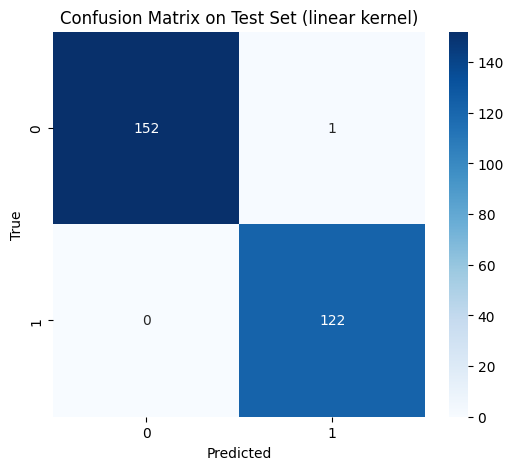

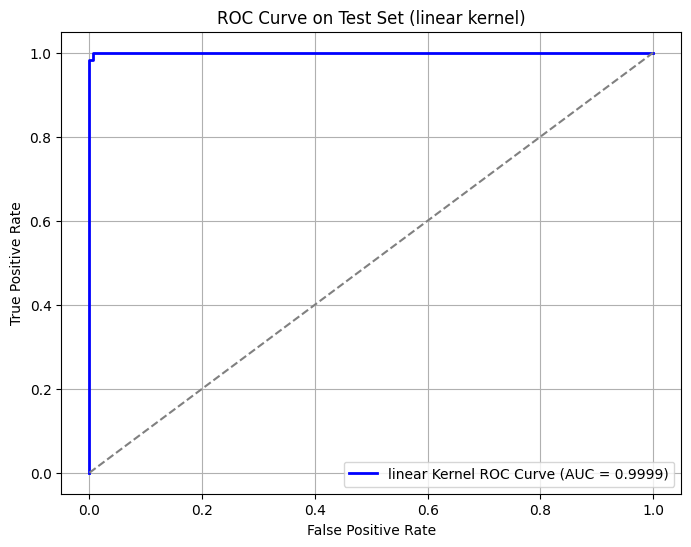


Test Accuracy (rbf kernel): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       122

    accuracy                           1.00       275
   macro avg       1.00      1.00      1.00       275
weighted avg       1.00      1.00      1.00       275



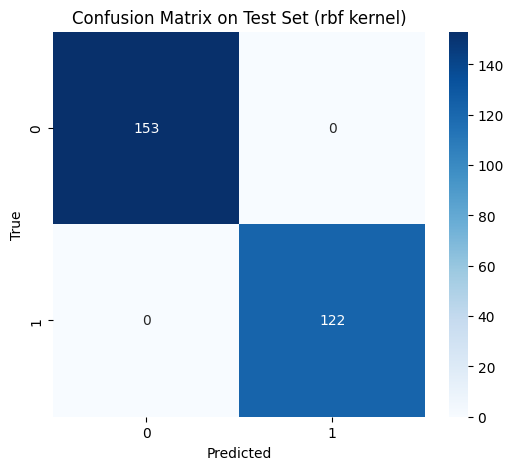

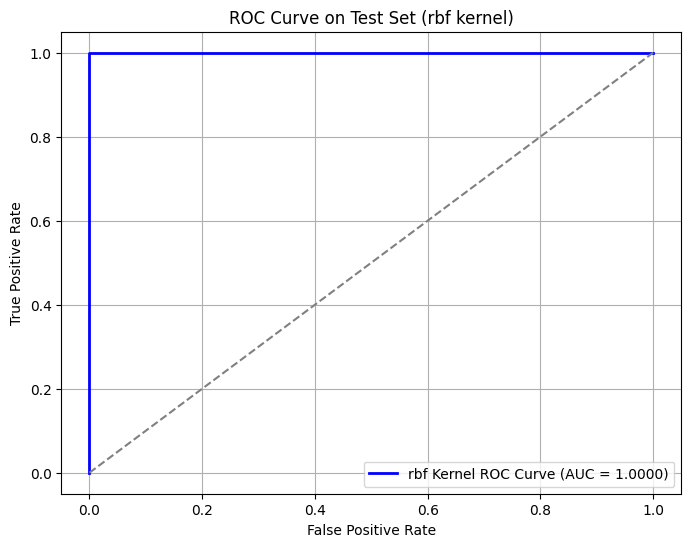

In [ ]:
# Test set predictions
def test_set_predictions(model, X_test, y_test, kernel):

    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"\nTest Accuracy ({kernel} kernel): {test_accuracy}")
    print(classification_report(y_test, y_test_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix on Test Set ({kernel} kernel)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Compute and plot the ROC Curve for the test set
    y_test_prob = model.predict_proba(X_test)  # Probabilities for the classes
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:, 1])  # Use probabilities for the positive class
    roc_auc = auc(fpr, tpr)  # Compute AUC

    # Plot the ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{kernel} Kernel ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal for random classification
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve on Test Set ({kernel} kernel)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Test set evaluation linear SVM
test_set_predictions(linear_svm_model, X_test_scaled, y_test, "linear")

# Test set evaluation for non-linear SVM - RBF
test_set_predictions(rbf_svm_model, X_test_scaled, y_test, "rbf")

# **GaussianMixture**

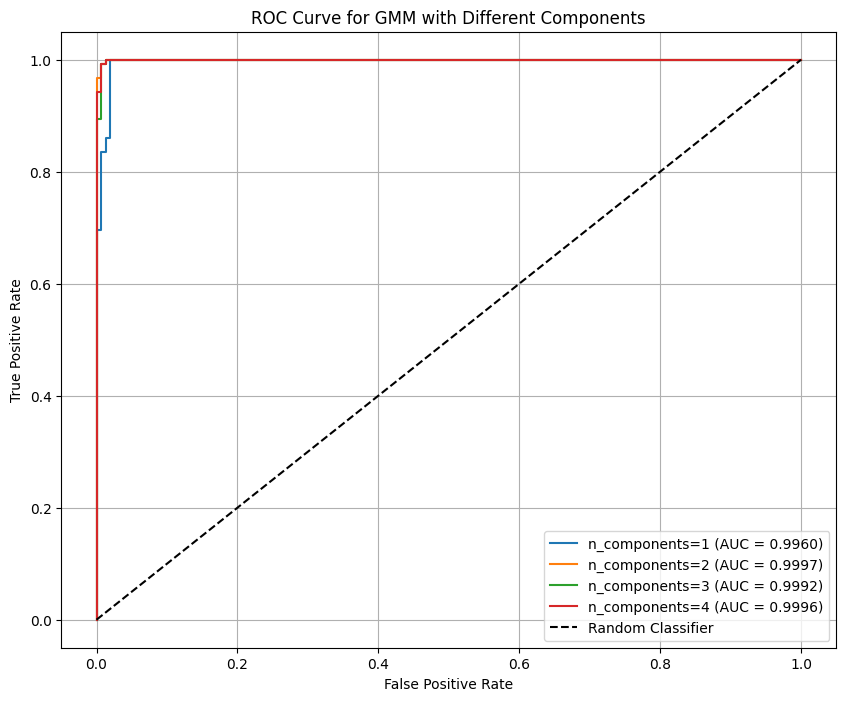

Best n_components: 2 with AUC = 0.9997


In [5]:
# Model GMM for positive samples (Class 1)
X_positive = X_train_scaled[y_train == 1]

# Evaluate different numbers of Gaussian components
n_components_list = [1, 2, 3, 4]
roc_auc_values = []

plt.figure(figsize=(10, 8))

for n_components in n_components_list:
    # Train GMM
    gmm = GaussianMixture(n_components=n_components, random_state=42)  # Set random_state for reproducibility
    gmm.fit(X_positive)

    # Compute probabilities for test data
    log_likelihood = gmm.score_samples(X_test_scaled)
    prob = np.exp(log_likelihood)

    # Compute and plot the ROC Curve for the test set
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    roc_auc_values.append(roc_auc)

    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f"n_components={n_components} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.title("ROC Curve for GMM with Different Components")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# best number of components based on ROC AUC
best_n_components = n_components_list[np.argmax(roc_auc_values)]
print(f"Best n_components: {best_n_components} with AUC = {max(roc_auc_values):.4f}")
